In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('INF2178_A3_data.csv')
data.head()

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2


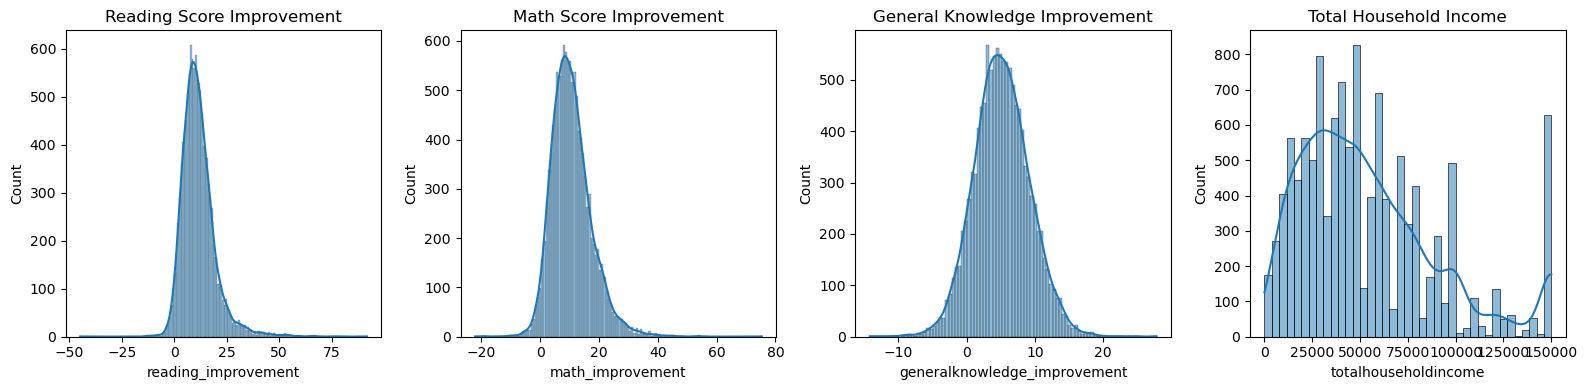

,reading_improvement,math_improvement,generalknowledge_improvement,totalhouseholdincome
count,11933.000000,11933.000000,11933.000000,11933.000000
mean,11.556963,10.671218,5.161890,54317.199930
std,8.085004,6.855263,4.054906,36639.061147
min,-44.760000,-22.160000,-14.183000,1.000000
25%,6.470000,6.010000,2.472000,27000.000000
50%,10.400000,9.860000,5.047000,47000.000000
75%,15.150000,14.330000,7.781000,72000.000000
max,91.940000,75.350000,27.785000,150000.000000


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate score improvements from fall to spring for each subject
data['reading_improvement'] = data['springreadingscore'] - data['fallreadingscore']
data['math_improvement'] = data['springmathscore'] - data['fallmathscore']
data['generalknowledge_improvement'] = data['springgeneralknowledgescore'] - data['fallgeneralknowledgescore']

# Summary statistics for the improvements and income
summary_stats = data[['reading_improvement', 'math_improvement', 'generalknowledge_improvement', 'totalhouseholdincome']].describe()

# Plotting distributions for score improvements and household income
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
sns.histplot(data['reading_improvement'], kde=True)
plt.title('Reading Score Improvement')

plt.subplot(1, 4, 2)
sns.histplot(data['math_improvement'], kde=True)
plt.title('Math Score Improvement')

plt.subplot(1, 4, 3)
sns.histplot(data['generalknowledge_improvement'], kde=True)
plt.title('General Knowledge Improvement')

plt.subplot(1, 4, 4)
sns.histplot(data['totalhouseholdincome'], kde=True)
plt.title('Total Household Income')

plt.tight_layout()
plt.show()

summary_stats


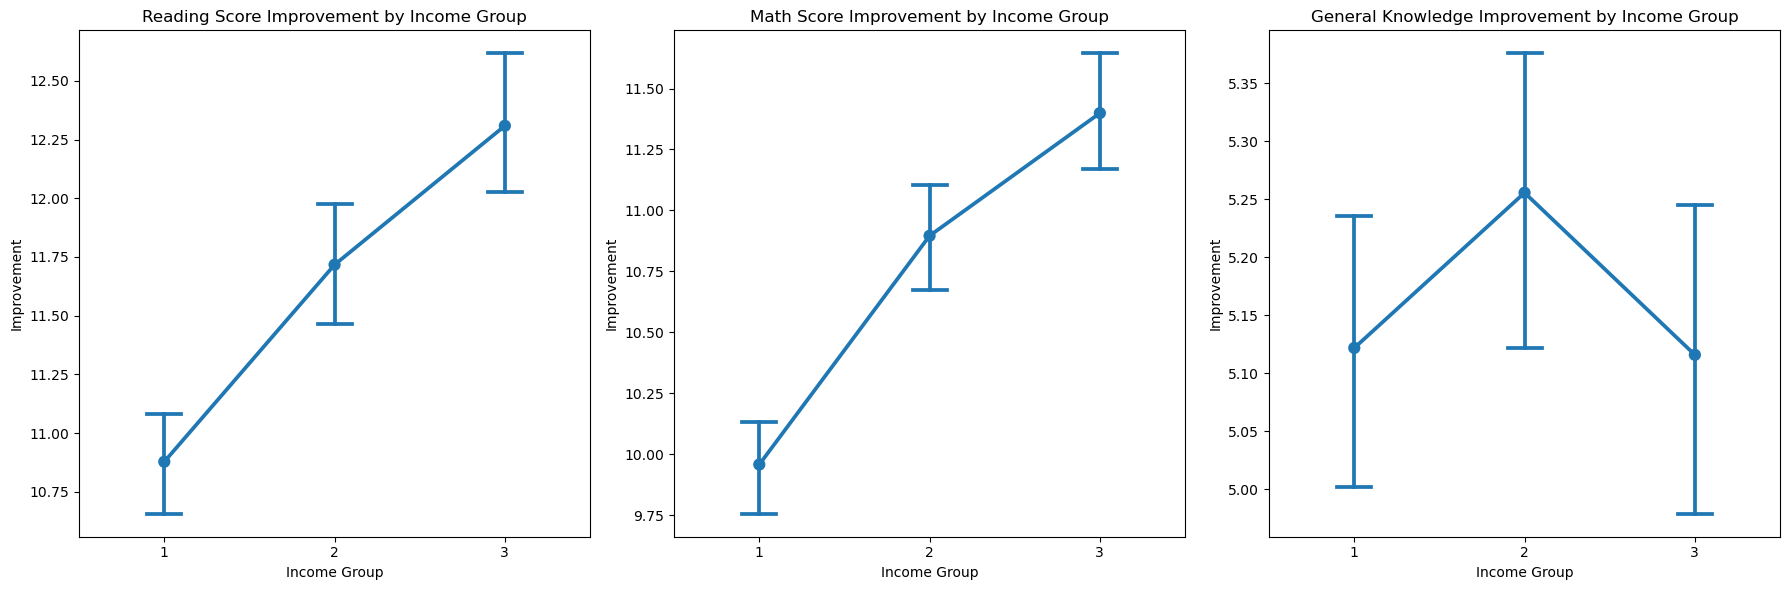

In [3]:
# Create interaction plots for each subject improvement vs. income group
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.pointplot(data=data, x='incomegroup', y='reading_improvement', capsize=.2)
plt.title('Reading Score Improvement by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Improvement')

plt.subplot(1, 3, 2)
sns.pointplot(data=data, x='incomegroup', y='math_improvement', capsize=.2)
plt.title('Math Score Improvement by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Improvement')

plt.subplot(1, 3, 3)
sns.pointplot(data=data, x='incomegroup', y='generalknowledge_improvement', capsize=.2)
plt.title('General Knowledge Improvement by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Improvement')

plt.tight_layout()
plt.show()


In [4]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan

# Function to check assumptions for ANCOVA
def check_assumptions(data, dependent, group, covariate):
    results = {}
    
    # Check for normality within each group
    results['normality'] = {g: stats.shapiro(data[data[group] == g][dependent]).pvalue for g in data[group].unique()}
    
    # Check for homogeneity of variances
    results['levene'] = stats.levene(*[data[data[group] == g][dependent] for g in data[group].unique()]).pvalue
    
    # Fit model to check homogeneity of regression slopes
    model = ols(f"{dependent} ~ C({group}) + {covariate} + C({group})*{covariate}", data=data).fit()
    # Perform ANOVA on model to check for interaction effect (homogeneity of slopes)
    anova_results = anova_lm(model, typ=2)
    results['homogeneity_of_slopes'] = anova_results.loc[f'C({group}):{covariate}', 'PR(>F)']
    
    return results, model

# Check assumptions for reading score improvement
reading_assumptions, reading_model = check_assumptions(data, 'reading_improvement', 'incomegroup', 'totalhouseholdincome')

reading_assumptions


{'normality': {3: 1.401298464324817e-45, 2: 3.363116314379561e-44, 1: 0.0},
 'levene': 2.794929503613517e-09,
 'homogeneity_of_slopes': 2.0561997106146038e-05}

In [5]:
# Fit ANCOVA model without the interaction term (since we aim to control for income, not explore its varying effect)
ancova_model = ols('reading_improvement ~ C(incomegroup) + totalhouseholdincome', data=data).fit()

# Perform ANOVA on the model to see if there's a significant effect of income group on reading improvement
ancova_results = anova_lm(ancova_model, typ=2)

# Display the ANCOVA results
print(ancova_results)


                             sum_sq       df          F    PR(>F)
C(incomegroup)           230.611199      2.0   1.775743  0.169402
totalhouseholdincome    1130.725900      1.0  17.413538  0.000030
Residual              774594.435176  11929.0        NaN       NaN


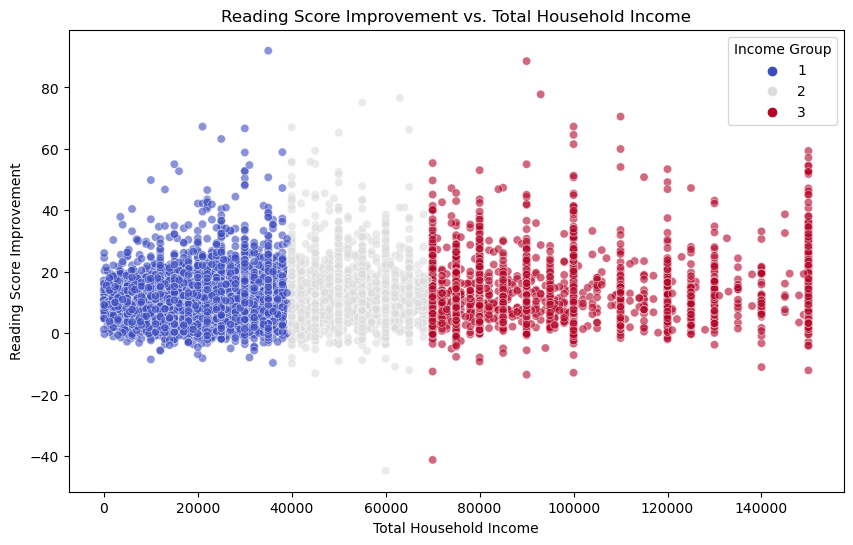

In [6]:
# Visualization of the relationship between total household income and reading score improvements
plt.figure(figsize=(10, 6))
sns.scatterplot(x='totalhouseholdincome', y='reading_improvement', hue='incomegroup', data=data, palette='coolwarm', alpha=0.6)
plt.title('Reading Score Improvement vs. Total Household Income')
plt.xlabel('Total Household Income')
plt.ylabel('Reading Score Improvement')
plt.legend(title='Income Group')
plt.show()


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2   0.8387    0.0 0.4246 1.2527   True
     1      3   1.4301    0.0 1.0079 1.8523   True
     2      3   0.5915 0.0053 0.1458 1.0371   True
--------------------------------------------------


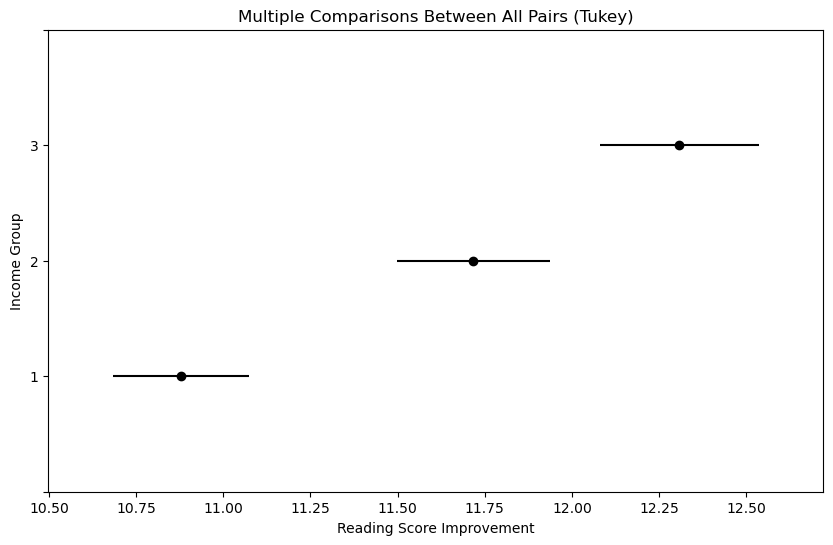

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Conduct Tukey's HSD test for pairwise comparisons between income groups
tukey_results = pairwise_tukeyhsd(endog=data['reading_improvement'],     # Data
                                  groups=data['incomegroup'],  # Groups
                                  alpha=0.05)                  # Significance level

# Print the results
print(tukey_results)

# Optionally, you can plot the results
tukey_results.plot_simultaneous(xlabel='Reading Score Improvement', ylabel='Income Group')
plt.show()
